<a href="https://colab.research.google.com/github/RuwaAbey/Finaly_Year_Project_G09/blob/main/Voleyball_keypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0+cu118 --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/usr/local/bin/python


In [3]:
import torch
import torchvision
import torchaudio
print("Torch version:", torch.__version__)

print("Torch version:", torchvision.__version__)
print("Torch version:", torchaudio.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.1.0+cu118
Torch version: 0.16.0+cu118
Torch version: 2.1.0+cu118
CUDA available: True


In [4]:
!pip install "numpy<2"

In [5]:
# install MMEngine, MMCV and MMDetection using MIM
%pip install -U openmim
!mim install mmengine
!mim install "mmcv==2.1.0"
!mim install "mmdet<3.3.0,>=3.0.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html
Ignoring mmcv: markers 'extra == "mim"' don't match your environment
Ignoring mmengine: markers 'extra == "mim"' don't match your environment


In [6]:
import mmcv
print("mmcv version:", mmcv.__version__)

mmcv version: 2.1.0


In [7]:
# for better Colab compatibility, install xtcocotools from source
%pip install git+https://github.com/jin-s13/xtcocoapi

  Cloning https://github.com/jin-s13/xtcocoapi to /tmp/pip-req-build-jna9v__a
  Running command git clone --filter=blob:none --quiet https://github.com/jin-s13/xtcocoapi /tmp/pip-req-build-jna9v__a
  Resolved https://github.com/jin-s13/xtcocoapi to commit d74033ff1635e9002133b2380862bc2b728584d2
  Preparing metadata (setup.py) ... done


In [8]:
!git clone https://github.com/open-mmlab/mmpose.git
# The master branch is version 1.x
%cd mmpose
%pip install -r requirements.txt
%pip install -v -e .
# "-v" means verbose, or more output
# "-e" means installing a project in editable mode,
# thus any local modifications made to the code will take effect without reinstallation.

fatal: destination path 'mmpose' already exists and is not an empty directory.
/content/mmpose
Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
Obtaining file:///content/mmpose
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-5n_ggwq4/mmpose.egg-info
  writing manifest file '/tmp/pip-pip-egg-info-5n_ggwq4/mmpose.egg-info/SOURCES.txt'
  writing manifest file '/tmp/pip-pip-egg-info-5n_ggwq4/mmpose.egg-info/SOURCES.txt'
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/jin-s13/xtcocoapi to /tmp/pip-install-s3d_h5o4/xtcocotools_8760890665884712a2a98d8ea8ad01a5
  Running command git version
  git version 2.34.1
  Running command git clone --filter=blob:none https://github.com/jin-s13/xtcocoapi /tmp/pip-install-s3d_h5o4/xtcocotools_8760890665884712a2a98d8ea8ad01a5
  Cloning into '/tmp/pip-install-s3d_h5o4/xtcocotools_8760890665884712a2a98d8ea8ad01a5'...
  Running command git rev-parse HEAD
  d740

In [9]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 2.1.0+cu118 True
torchvision version: 0.16.0+cu118
mmpose version: 1.3.2
cuda version: 11.8
compiler information: GCC 9.3


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np

def load_detections_for_target_frame(file_path, target_frame):
    """
    Load detections from a file and extract bounding boxes for the target frame.

    Args:
        file_path (str): Path to the detection file.
        target_frame (str): The name of the frame to extract detections for.

    Returns:
        np.ndarray: Bounding boxes for the target frame in the format [x1, y1, x2, y2, confidence].
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        image_id = parts[0]  # Image filename (e.g., "51705.jpg")

        # Process only the target frame
        if image_id == target_frame:
            num_players = (len(parts) - 2) // 6  # Each player has 6 values (X, Y, W, H, Confidence, "person")
            boxes = []

            for i in range(num_players):
                x = int(parts[2 + i * 6])  # X-coordinate
                y = int(parts[3 + i * 6])  # Y-coordinate
                w = int(parts[4 + i * 6])  # Width
                h = int(parts[5 + i * 6])  # Height
                confidence = float(parts[6 + i * 6])  # Confidence Score
                label = parts[7 + i * 6]  # The "person" string

                if confidence > 0.5 and label == "person":  # Apply confidence filter
                    boxes.append([x, y, x + w, y + h, confidence])  # Convert to [x1, y1, x2, y2, score]

            return np.array(boxes) if boxes else np.empty((0, 5))  # Return an array or an empty array if no boxes

    return np.empty((0, 5))  # Return an empty array if the target frame is not found


# Example usage
file_path = '/content/drive/My Drive/Datasets/Volleyball_dataset/skeleton_data_making_sample/Bounding_box_data/38025/person_detections.txt'  # Replace with your file path
target_frame = '38005.jpg'
boxes = load_detections_for_target_frame(file_path, target_frame)

# Print results
print(f"Bounding boxes for {target_frame}:")
print(boxes)


Bounding boxes for 38005.jpg:
[[9.84000000e+02 3.52000000e+02 1.08400000e+03 4.97000000e+02
  9.99368250e-01]
 [1.15000000e+03 3.55000000e+02 1.24100000e+03 4.91000000e+02
  9.98844624e-01]
 [7.61000000e+02 3.98000000e+02 8.21000000e+02 5.32000000e+02
  9.96759593e-01]
 [9.81000000e+02 5.34000000e+02 1.03600000e+03 6.77000000e+02
  9.94184077e-01]
 [6.47000000e+02 3.98000000e+02 7.21000000e+02 5.24000000e+02
  9.93867815e-01]
 [1.18100000e+03 4.57000000e+02 1.22800000e+03 5.96000000e+02
  9.89714444e-01]
 [6.13000000e+02 4.04000000e+02 6.59000000e+02 5.41000000e+02
  9.76711750e-01]
 [5.58000000e+02 4.39000000e+02 6.00000000e+02 5.73000000e+02
  9.73904550e-01]
 [6.27000000e+02 3.52000000e+02 6.78000000e+02 4.84000000e+02
  9.26878452e-01]]


In [12]:
import torch

def load_detections_as_tensor(file_path, target_frame):
    """
    Load detections from a file and extract bounding boxes for the target frame.

    Args:
        file_path (str): Path to the detection file.
        target_frame (str): The name of the frame to extract detections for.

    Returns:
        torch.Tensor: Bounding boxes for the target frame in the format [x1, y1, x2, y2].
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        image_id = parts[0]  # Image filename (e.g., "51705.jpg")

        # Process only the target frame
        if image_id == target_frame:
            num_players = (len(parts) - 2) // 6  # Each player has 6 values (X, Y, W, H, Confidence, "person")
            boxes = []

            for i in range(num_players):
                x = int(parts[2 + i * 6])  # X-coordinate
                y = int(parts[3 + i * 6])  # Y-coordinate
                w = int(parts[4 + i * 6])  # Width
                h = int(parts[5 + i * 6])  # Height
                confidence = float(parts[6 + i * 6])  # Confidence Score
                label = parts[7 + i * 6]  # The "person" string

                if confidence > 0.5 and label == "person":  # Apply confidence filter
                    boxes.append([x, y, x + w, y + h])  # Convert to [x1, y1, x2, y2]

            return torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)

    return torch.empty((0, 4), dtype=torch.float32)  # Return an empty tensor if the target frame is not found

# Example usage
file_path = '/content/drive/My Drive/Datasets/Volleyball_dataset/skeleton_data_making_sample/Bounding_box_data/38025/person_detections.txt'  # Replace with your file path
target_frame = '38005.jpg'
bounding_boxes = load_detections_as_tensor(file_path, target_frame)

# Print results
print(f"Bounding boxes for {target_frame}:")
print(bounding_boxes)


Bounding boxes for 38005.jpg:
tensor([[ 984.,  352., 1084.,  497.],
        [1150.,  355., 1241.,  491.],
        [ 761.,  398.,  821.,  532.],
        [ 981.,  534., 1036.,  677.],
        [ 647.,  398.,  721.,  524.],
        [1181.,  457., 1228.,  596.],
        [ 613.,  404.,  659.,  541.],
        [ 558.,  439.,  600.,  573.],
        [ 627.,  352.,  678.,  484.]])


In [13]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

img = '/content/drive/My Drive/Datasets/Volleyball_dataset/skeleton_data_making_sample/Image/38025/38005.jpg'  # Replace with your file path'
pose_config = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device = 'cuda:0'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))


# build detector
detector = init_detector(
    det_config,
    det_checkpoint,
    device=device
)


# build pose estimator
pose_estimator = init_pose_estimator(
    pose_config,
    pose_checkpoint,
    device=device,
    cfg_options=cfg_options
)

# init visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


In [14]:
# Convert bounding_boxes tensor to numpy array
if isinstance(bounding_boxes, torch.Tensor):
  bounding_boxes = bounding_boxes.cpu().numpy()

pose_results = inference_topdown(pose_estimator, img, bounding_boxes)

In [15]:
data_samples = merge_data_samples(pose_results)

In [16]:
img = mmcv.imread(img, channel_order='rgb')

In [17]:
def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file,bounding_boxes):
    """Visualize predicted keypoints (and heatmaps) of one image."""


    bboxes = bounding_boxes

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    #####################33333333


    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [18]:
print(pose_results)

[<PoseDataSample(

    META INFORMATION
    pad_shape: (256, 192)
    input_size: (192, 256)
    input_center: array([1034. ,  424.5], dtype=float32)
    img_path: '/content/drive/My Drive/Datasets/Volleyball_dataset/skeleton_data_making_sample/Image/38025/38005.jpg'
    input_scale: array([135.9375, 181.25  ], dtype=float32)
    flip_indices: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    img_shape: (720, 1280)
    dataset_name: 'coco'
    ori_shape: (720, 1280)
    batch_input_shape: (256, 192)

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bbox_scores: array([1.], dtype=float32)
            keypoints: array([[[1041.7881 ,  372.81543],
                        [1043.2041 ,  369.9834 ],
                        [1040.3721 ,  369.9834 ],
                        [1046.0361 ,  371.3994 ],
                        [1036.124  ,  369.9834 ],
                        [1051.7002 ,  381.31152],


In [19]:
visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=0,
        out_file=None,
        kpt_thr=0.3)
vis_result = visualizer.get_image()

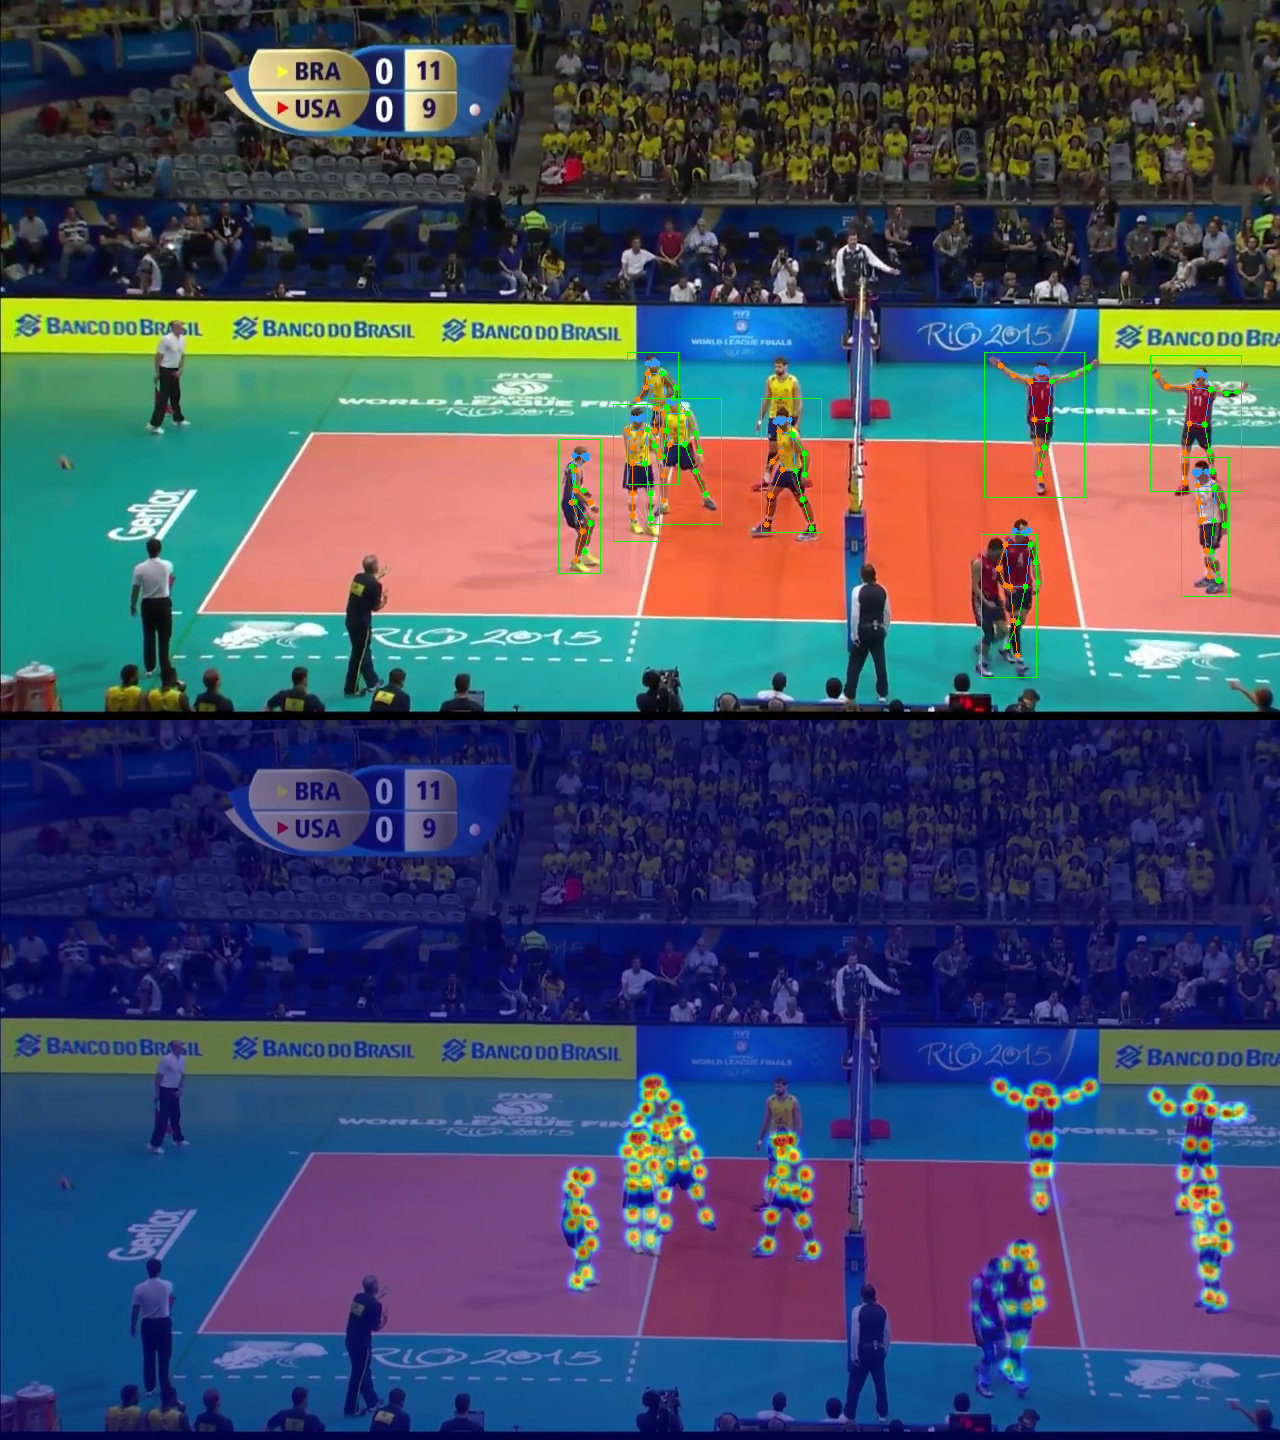

In [20]:

if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    import cv2
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result[:,:,::-1])
        display(Image(file_name))
else:
    cv2_imshow(vis_result[:,:,::-1]) #RGB2BGR to fit cv2

In [21]:
import numpy as np

all_keypoints = []  # Use a list to store keypoints
all_scores = []     # Use a list to store scores

for pose_result in pose_results:
    keypoints = pose_result.pred_instances.keypoints  # Shape: (N, num_keypoints, 2)
    scores = pose_result.pred_instances.keypoint_scores  # Shape: (N, num_keypoints)

    all_keypoints.append(keypoints)
    all_scores.append(scores)

# Convert to numpy arrays after appending all the results
all_keypoints = np.array(all_keypoints)  # Shape: (num_people, num_keypoints, 2)
all_scores = np.array(all_scores)  # Shape: (num_people, num_keypoints)

print("Extracted Keypoints:\n", all_keypoints)
print("Extracted Keypoint Scores:\n", all_scores)


Extracted Keypoints:
 [[[[1041.7881   372.81543]
   [1043.2041   369.9834 ]
   [1040.3721   369.9834 ]
   [1046.0361   371.3994 ]
   [1036.124    369.9834 ]
   [1051.7002   381.31152]
   [1030.46     381.31152]
   [1072.9404   374.23145]
   [1013.4678   375.64746]
   [1088.5166   367.15137]
   [1000.72363  365.73535]
   [1047.4521   419.54395]
   [1034.708    419.54395]
   [1044.6201   447.86426]
   [1037.54     449.28027]
   [1038.956    473.35254]
   [1040.3721   479.0166 ]]]


 [[[1198.8203   374.52344]
   [1201.4766   373.1953 ]
   [1197.4922   371.8672 ]
   [1205.4609   375.85156]
   [1196.1641   374.52344]
   [1210.7734   389.1328 ]
   [1189.5234   387.8047 ]
   [1226.7109   393.1172 ]
   [1166.9453   386.47656]
   [1237.3359   391.78906]
   [1156.3203   375.85156]
   [1204.1328   424.9922 ]
   [1189.5234   423.66406]
   [1209.4453   451.5547 ]
   [1184.2109   452.8828 ]
   [1212.1016   471.47656]
   [1184.2109   482.10156]]]


 [[[ 781.18555  422.4707 ]
   [ 783.80273  419.85352

In [22]:
import numpy as np

all_keypoints = []  # Use a list to store keypoints
all_scores = []     # Use a list to store scores

for pose_result in pose_results:
    keypoints = pose_result.pred_instances.keypoints  # Shape: (N, num_keypoints, 2)
    scores = pose_result.pred_instances.keypoint_scores  # Shape: (N, num_keypoints)

    all_keypoints.append(keypoints)
    all_scores.append(scores)

# Convert to numpy arrays after appending all the results
all_keypoints = np.array(all_keypoints)  # Shape: (num_people, num_keypoints, 2)
all_scores = np.array(all_scores)  # Shape: (num_people, num_keypoints)

# Create a dictionary to return
result = {
    "keypoints": all_keypoints,
    "scores": all_scores
}

# Return the dictionary
#print("Extracted Keypoints:\n", all_keypoints)
#print("Extracted Keypoint Scores:\n", all_scores)
print(result)
# Returning the dictionary (in case this code is inside a function)
# return result


{'keypoints': array([[[[1041.7881 ,  372.81543],
         [1043.2041 ,  369.9834 ],
         [1040.3721 ,  369.9834 ],
         [1046.0361 ,  371.3994 ],
         [1036.124  ,  369.9834 ],
         [1051.7002 ,  381.31152],
         [1030.46   ,  381.31152],
         [1072.9404 ,  374.23145],
         [1013.4678 ,  375.64746],
         [1088.5166 ,  367.15137],
         [1000.72363,  365.73535],
         [1047.4521 ,  419.54395],
         [1034.708  ,  419.54395],
         [1044.6201 ,  447.86426],
         [1037.54   ,  449.28027],
         [1038.956  ,  473.35254],
         [1040.3721 ,  479.0166 ]]],


       [[[1198.8203 ,  374.52344],
         [1201.4766 ,  373.1953 ],
         [1197.4922 ,  371.8672 ],
         [1205.4609 ,  375.85156],
         [1196.1641 ,  374.52344],
         [1210.7734 ,  389.1328 ],
         [1189.5234 ,  387.8047 ],
         [1226.7109 ,  393.1172 ],
         [1166.9453 ,  386.47656],
         [1237.3359 ,  391.78906],
         [1156.3203 ,  375.85156],
  

In [52]:
import pickle

# Create a dictionary to save (use your existing result dictionary)
result = {
    "keypoints": all_keypoints,
    "scores": all_scores
}

# Specify the path to save in Google Drive
pickle_file = '/content/drive/MyDrive/pose_results.pkl'

# Save the dictionary to the pickle file in Google Drive
with open(pickle_file, 'wb') as f:
    pickle.dump(result, f)

print(f"Dictionary saved to {pickle_file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dictionary saved and download started for pose_results.pkl
